# Visualisations - Analyse des Alertes ANSSI & Enrichissement CVE

## Imports préalables

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# 1️⃣ Racine = dossier parent de notebooks/
PROJECT_ROOT = Path.cwd().resolve().parent
print("📁 Racine projet :", PROJECT_ROOT)

# 2️⃣ Rendre les modules internes importables
sys.path.insert(0, str(PROJECT_ROOT))

# 3️⃣ Chemins communs
DATA_CSV   = PROJECT_ROOT / "data" / "processed" / "final_dataset.csv"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)   # ✅ syntaxe correcte

print("CSV présent :", DATA_CSV.exists(), "-", DATA_CSV)

# 4️⃣ Imports internes (désormais visibles)
from src.extract_cves import extract_all_entries
from src.consolidate import build_dataframe

📁 Racine projet : C:\Users\thoma\OneDrive\Bureau\Atelier-Data\AtelierDS_PRJ
CSV présent : True - C:\Users\thoma\OneDrive\Bureau\Atelier-Data\AtelierDS_PRJ\data\processed\final_dataset.csv


## Gravité et risques d'exploitation

### Scatter « CVSS × EPSS »

Nous cherchons à savoir **quelles CVE cumulent sévérité et probabilité**.

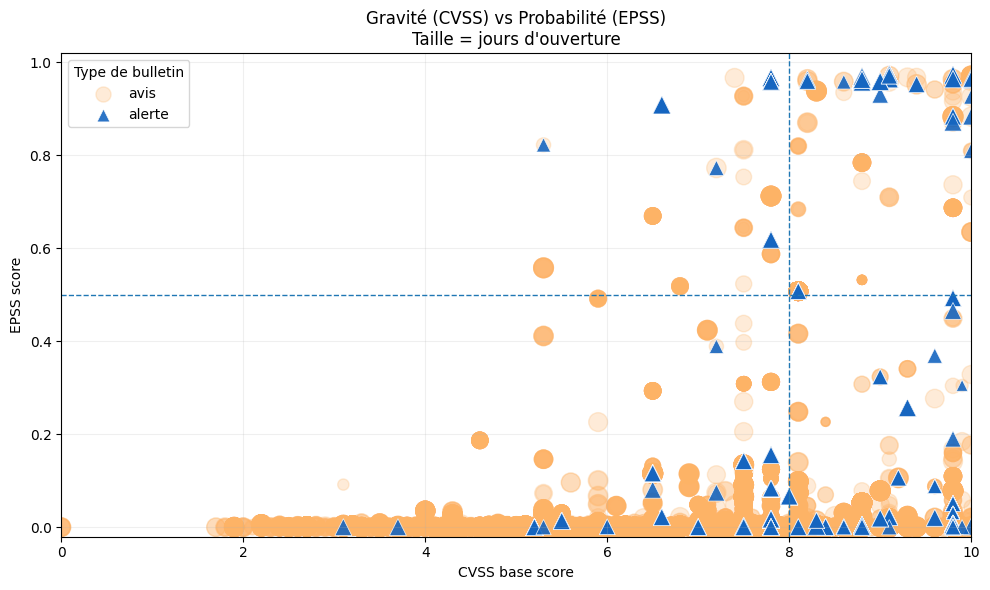

637 urgences enregistrées → C:\Users\thoma\OneDrive\Bureau\Atelier-Data\AtelierDS_PRJ\outputs\urgences_cve.csv


In [11]:
df = pd.read_csv(DATA_CSV, parse_dates=["date", "closed_at"])

# Nettoyage minimal
df = df.dropna(subset=["cvss_score", "epss_score"])
df["cvss_score"] = pd.to_numeric(df["cvss_score"], errors="coerce")
df["epss_score"] = pd.to_numeric(df["epss_score"], errors="coerce")

# Taille des bulles : log(1 + days_open) pour garder lisible
df["size_pt"] = np.log1p(df["days_open"]).fillna(0) * 30

plt.figure(figsize=(10, 6))

# 1️⃣ tracer d’abord les AVIS (orange, transparence)
subset_avis = df[df["type"] == "avis"]
plt.scatter(
    subset_avis["cvss_score"],
    subset_avis["epss_score"],
    s=subset_avis["size_pt"],
    c="#FDB366",                  # orange plus clair
    alpha=0.25,                   # forte transparence
    label="avis",
    marker="o"
)

# 2️⃣ tracer ensuite les ALERTES (bleu, opaques, bord blanc)
subset_alertes = df[df["type"] == "alerte"]
plt.scatter(
    subset_alertes["cvss_score"],
    subset_alertes["epss_score"],
    s=subset_alertes["size_pt"],
    c="#1565C0",                  # bleu plus sombre
    alpha=0.9,
    label="alerte",
    marker="^",                   # triangle
    edgecolors="white",
    linewidths=0.5
)

# Lignes seuils
plt.axvline(8,  linestyle="--", linewidth=1)
plt.axhline(0.5, linestyle="--", linewidth=1)

plt.xlabel("CVSS base score")
plt.ylabel("EPSS score")
plt.title("Gravité (CVSS) vs Probabilité (EPSS)\nTaille = jours d'ouverture")
plt.legend(title="Type de bulletin")
plt.ylim(-0.02, 1.02)
plt.xlim(0, 10)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Export des urgences (quadrant haut-droit)
urgences = df[(df["cvss_score"] >= 8) & (df["epss_score"] >= 0.5)]
urgences.to_csv(OUTPUT_DIR / "urgences_cve.csv", index=False, encoding="utf-8")
print(f"{len(urgences)} urgences enregistrées → {OUTPUT_DIR / 'urgences_cve.csv'}")

### Histogramme empilé des scores CVSS

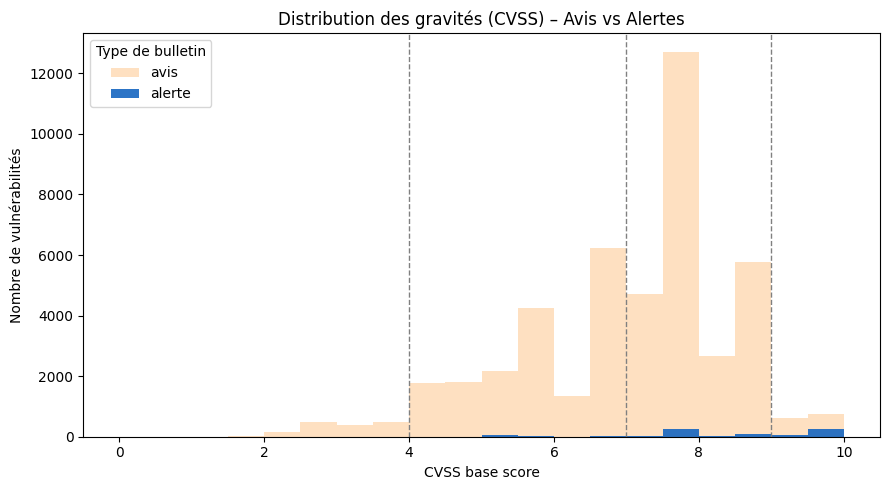

In [12]:
# 1. Sélection des scores valides
avis_cvss     = df[df["type"] == "avis"]["cvss_score"].dropna()
alertes_cvss  = df[df["type"] == "alerte"]["cvss_score"].dropna()

# 2. Bins 0 → 10 par pas de 0.5
bins = np.arange(0, 10.5, 0.5)

plt.figure(figsize=(9, 5))

# 1. Avis en premier
plt.hist(
    avis_cvss,
    bins=bins,
    color="#FDB366",
    alpha=0.4,
    label="avis",
)

# 2. Alertes par-dessus
plt.hist(
    alertes_cvss,
    bins=bins,
    color="#1565C0",
    alpha=0.9,
    label="alerte",
    stacked=True  # pas indispensable ici, mais garde le même rendu
)

# seuils CVSS
for x in (4, 7, 9):
    plt.axvline(x, linestyle="--", color="grey", linewidth=1)

plt.xlabel("CVSS base score")
plt.ylabel("Nombre de vulnérabilités")
plt.title("Distribution des gravités (CVSS) – Avis vs Alertes")
plt.legend(title="Type de bulletin")
plt.tight_layout()
plt.show()

### Violin plot EPSS par quartile CVSS

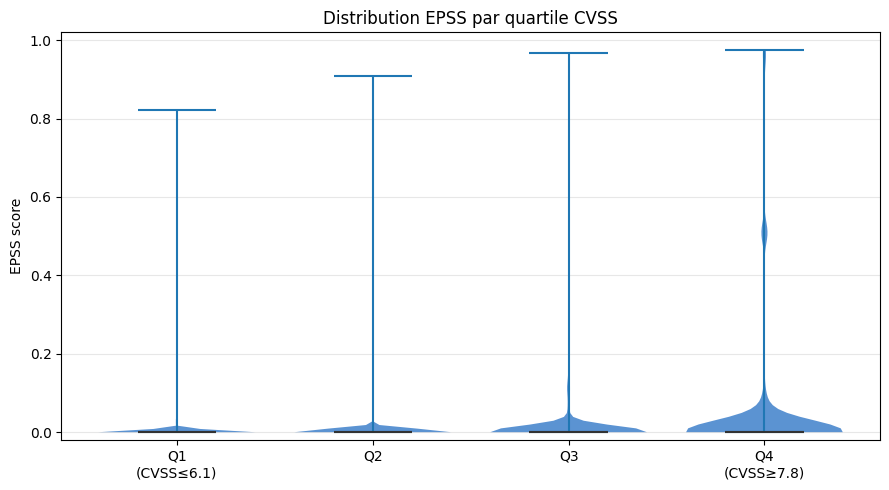

In [13]:
# 1. Conserver uniquement lignes scorées
d = df.dropna(subset=["cvss_score", "epss_score"]).copy()

# 2. Quartiles basés sur la distribution CVSS
d["cvss_quartile"] = pd.qcut(d["cvss_score"], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

# 3. Préparer les données pour le violin plot
grouped_epss = [d[d["cvss_quartile"] == q]["epss_score"] for q in ["Q1", "Q2", "Q3", "Q4"]]

plt.figure(figsize=(9, 5))
parts = plt.violinplot(
    grouped_epss,
    showmeans=False,
    showmedians=True,
    widths=0.8
)

# 4. Esthétique basique
for pc in parts["bodies"]:
    pc.set_facecolor("#1565C0")
    pc.set_alpha(0.7)

median_color = "#333333"
parts["cmedians"].set_color(median_color)

quartile_labels = [
    f"Q1\n(CVSS≤{d['cvss_score'].quantile(0.25):.1f})",
    "Q2",
    "Q3",
    f"Q4\n(CVSS≥{d['cvss_score'].quantile(0.75):.1f})",
]

plt.xticks(
    ticks=[1, 2, 3, 4],
    labels=quartile_labels
)
plt.ylabel("EPSS score")
plt.title("Distribution EPSS par quartile CVSS")
plt.ylim(-0.02, 1.02)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Courbe cumulative des vulnérabilités en fonction du temps

Montrer l’évolution temporelle du nombre de vulnérabilités détectées

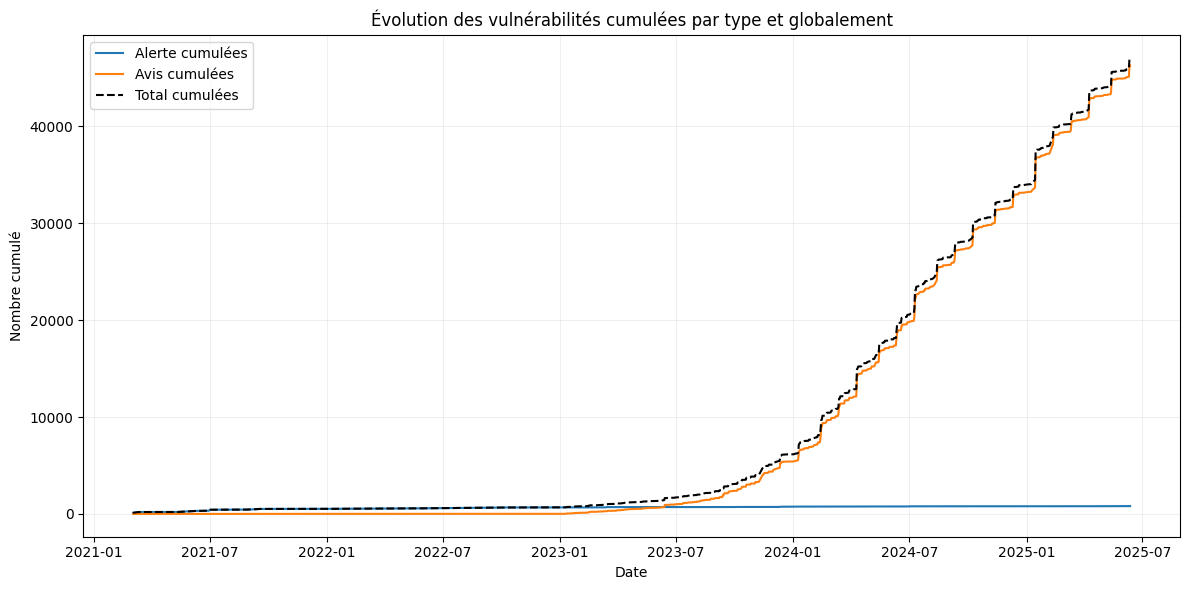

In [14]:
plt.figure(figsize=(12, 6))

# Regrouper par date et compter les vulnérabilités cumulées pour chaque type
vulnerabilites_cumulatives_par_type = df.groupby(["date", "type"]).size().unstack(fill_value=0).cumsum()

# Tracer les courbes cumulées par type
for col in vulnerabilites_cumulatives_par_type.columns:
    plt.plot(
        vulnerabilites_cumulatives_par_type.index,
        vulnerabilites_cumulatives_par_type[col],
        label=f"{col.capitalize()} cumulées"
    )

# Tracer la courbe cumulée globale
vulnerabilites_cumulatives_totales = df.groupby("date").size().cumsum()
plt.plot(
    vulnerabilites_cumulatives_totales.index,
    vulnerabilites_cumulatives_totales.values,
    color="black",
    linestyle="--",
    label="Total cumulées"
)

plt.xlabel("Date")
plt.ylabel("Nombre cumulé")
plt.title("Évolution des vulnérabilités cumulées par type et globalement")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### Stacked Area :

Total des vulnérabilités vs subset "CVSS >= 8 et EPSS >= 0.5" : **Suit l'évolution du "backlog critique"**

C:\Users\thoma\AppData\Local\Temp\ipykernel_12092\1747415050.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



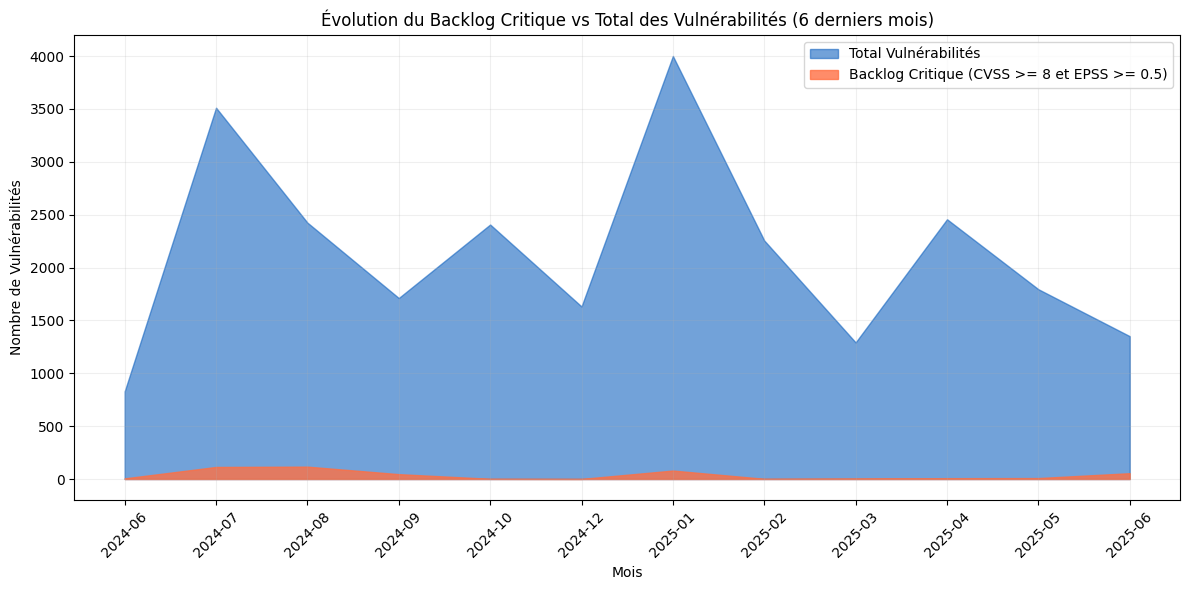

In [54]:
# Définir la date limite (6 mois avant aujourd'hui)
date_limite = pd.Timestamp.now() - pd.DateOffset(months=12)

# Filtrer les données pour la période récente
df_recent = df[df["date"] >= date_limite]

# Regroupement par mois pour les vulnérabilités totales et critiques
df_recent["month"] = df_recent["date"].dt.to_period("M")
monthly_total_recent = df_recent.groupby("month").size()

critical_subset_recent = df_recent[(df_recent["cvss_score"] >= 8) & (df_recent["epss_score"] >= 0.5)]
monthly_critical_recent = critical_subset_recent.groupby("month").size()

# Alignement des index pour éviter les NaN
monthly_total_recent = monthly_total_recent.reindex(monthly_critical_recent.index, fill_value=0)

plt.figure(figsize=(12, 6))

# Plot des données mensuelles pour la période récente
plt.fill_between(monthly_total_recent.index.astype(str), monthly_total_recent.values, color="#1565C0", alpha=0.6, label="Total Vulnérabilités")
plt.fill_between(monthly_critical_recent.index.astype(str), monthly_critical_recent.values, color="#FF7043", alpha=0.8, label="Backlog Critique (CVSS >= 8 et EPSS >= 0.5)")

plt.xlabel("Mois")
plt.ylabel("Nombre de Vulnérabilités")
plt.xticks(rotation=45)
plt.title("Évolution du Backlog Critique vs Total des Vulnérabilités (6 derniers mois)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

Peut-être modifier la fenêtre temporelle

### Boxplot des scores CVSS par éditeur

Montrer **la dispersion des scores CVSS** pour les éditeurs les plus affectés.

<Figure size 1200x600 with 0 Axes>

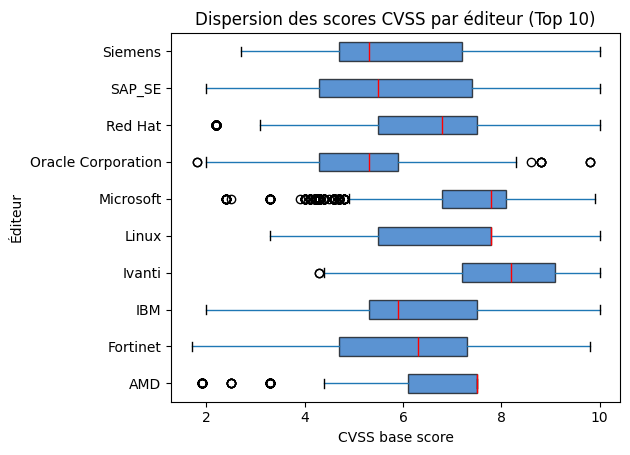

In [16]:
plt.figure(figsize=(12, 6))

# Filter top vendors by count of vulnerabilities
top_vendors = df["vendor"].value_counts().head(10).index
subset_top_vendors = df[df["vendor"].isin(top_vendors)]

# Create boxplot
subset_top_vendors.boxplot(
    column="cvss_score",
    by="vendor",
    grid=False,
    patch_artist=True,
    boxprops=dict(facecolor="#1565C0", alpha=0.7),
    medianprops=dict(color="red"),
    vert=False
)

plt.title("Dispersion des scores CVSS par éditeur (Top 10)")
plt.suptitle("")  # Remove default title
plt.xlabel("CVSS base score")
plt.ylabel("Éditeur")
plt.tight_layout()
plt.show()

## Dimensions techniques

### Top 20 des faiblesses (CWE)

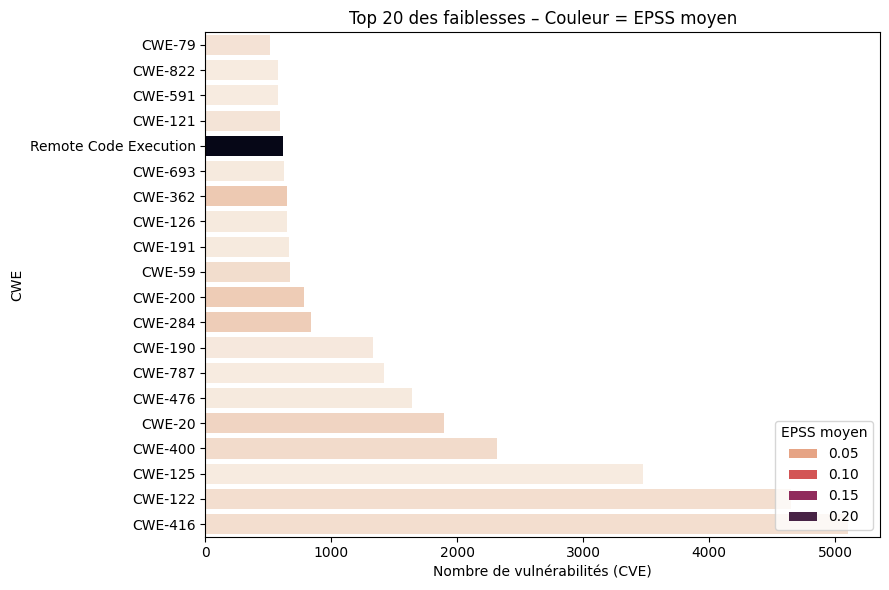

In [17]:
# 1) filtrer lignes disposant d’un CWE
d_cwe = df.dropna(subset=["cwe"])

# 2) agrégation : nombre de CVE et EPSS moyen
top_cwe = (
    d_cwe.groupby("cwe", as_index=False)
         .agg(nb=("cwe", "size"),
              epss_moy=("epss_score", "mean"))
         .sort_values("nb", ascending=False)
         .head(20)
         .sort_values("nb")          # pour plot horizontal ascendant
)

# 3) barplot horizontal, palette graduée sur l’EPSS moyen
plt.figure(figsize=(9, 6))
sns.barplot(
    data=top_cwe,
    x="nb",
    y="cwe",
    hue="epss_moy",
    palette="rocket_r",
    dodge=False
)

plt.xlabel("Nombre de vulnérabilités (CVE)")
plt.ylabel("CWE")
plt.title("Top 20 des faiblesses – Couleur = EPSS moyen")
plt.legend(title="EPSS moyen", loc="lower right")
plt.tight_layout()
plt.show()


### Courbe de l'évolution de différent CWE au cours du temps

Permet d'observer l'évolution d'un type de CWE

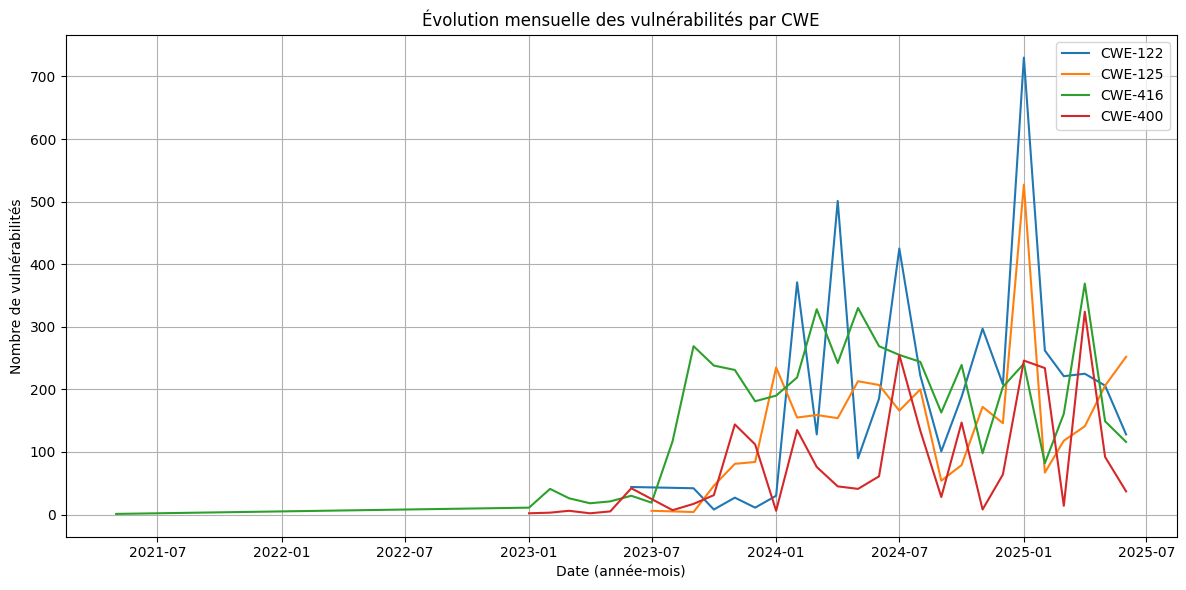

In [18]:
cwe_list = ["CWE-122", "CWE-125", "CWE-416", "CWE-400"]

plt.figure(figsize=(12, 6))

for cwe in cwe_list:
    temp = df[df["cwe"] == cwe].copy()
    temp["date"] = pd.to_datetime(temp["date"], errors='coerce')
    temp = temp.dropna(subset=["date"])
    
    # Extraire l'année + mois
    temp["year_month"] = temp["date"].dt.to_period("M")
    
    # Compter le nombre de vulnérabilités par mois
    counts = temp["year_month"].value_counts().sort_index()
    
    # Convertir pour le tracé
    counts.index = counts.index.to_timestamp()
    
    plt.plot(counts.index, counts.values, label=cwe)

plt.title("Évolution mensuelle des vulnérabilités par CWE")
plt.xlabel("Date (année-mois)")
plt.ylabel("Nombre de vulnérabilités")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Heat-map Vendor × CWE

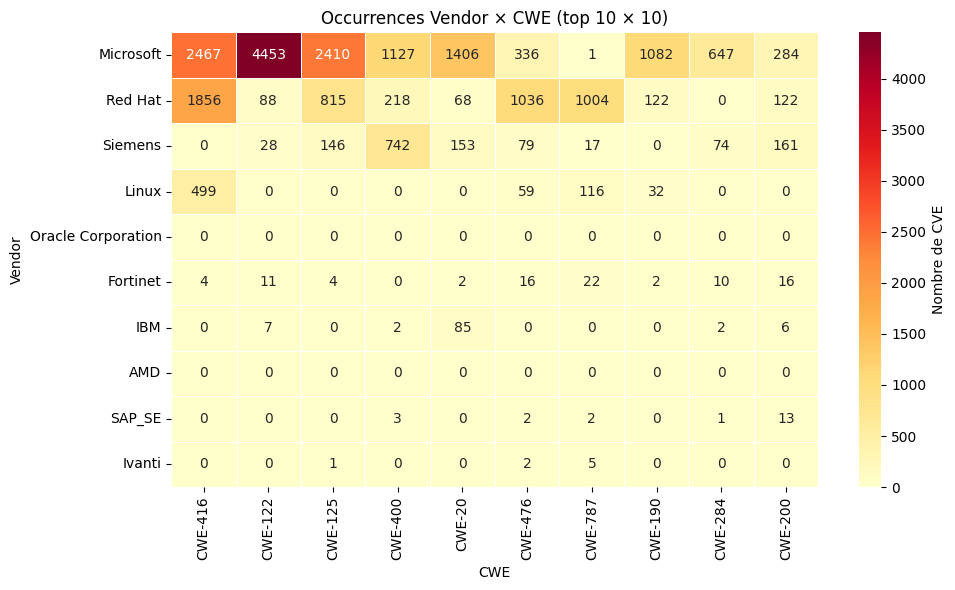

In [19]:
# 1) périmètre raisonnable : top 10 vendors & top 10 CWE
top_vendors = df["vendor"].value_counts().head(10).index
top_cwes    = df["cwe"].value_counts().head(10).index

sub = df[df["vendor"].isin(top_vendors) & df["cwe"].isin(top_cwes)]

# 2) matrice Vendor × CWE
pivot = (
    sub.groupby(["vendor", "cwe"])
        .size()
        .unstack(fill_value=0)
)

# 3) forcer l’ordre ET compléter les manquants avec 0
pivot = (
    pivot.reindex(index=top_vendors, columns=top_cwes, fill_value=0)
)

# 4) tracé heat-map
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    annot=True, fmt="d", linewidths=.5,
    cmap="YlOrRd", cbar_kws={"label": "Nombre de CVE"}
)
plt.title("Occurrences Vendor × CWE (top 10 × 10)")
plt.xlabel("CWE")
plt.ylabel("Vendor")
plt.tight_layout()
plt.show()


### Treemap Bulletins, pour la taille d'impact des bulletins

Déniche les bulletins "massifs", parfois sous-estimés


In [56]:
import plotly.express as px

# Définir la date limite (6 mois avant aujourd'hui)
date_limite = pd.Timestamp.now() - pd.DateOffset(months=4)

# Calcul le nombre de produits affectés par CVE
df["n_affected_products"] = df["versions"].apply(lambda x: len(str(x).split("|")) if pd.notnull(x) else 0)

# Filtre pour les 100 plus impactants
top_50_alertes_avis = df[df["type"].isin(["alerte", "avis"])].nlargest(200, "n_affected_products")

# Filtrer les bulletins récents
bulletins_recents = top_50_alertes_avis[top_50_alertes_avis["date"] >= date_limite]

# Agrégation pour la treemap
treemap_data = bulletins_recents.groupby(["type", "id_anssi", "date"]).agg(
    n_affected_products=("n_affected_products", "sum"),
    titre=("titre", "first")
).reset_index()


treemap_data = treemap_data.sort_values(by="n_affected_products", ascending=False)


# Créer une treemap avec plotly.express
fig = px.treemap(
    treemap_data,
    path=["type", "date","id_anssi", "titre"],
    color="n_affected_products",
    values="n_affected_products",
    color_continuous_scale='RdBu',
    color_continuous_midpoint=np.average(treemap_data['n_affected_products'], weights=treemap_data['n_affected_products'])
)

fig.update_layout(
    title="Treemap Bulletins - Taille d'impact des bulletins",
    margin=dict(t=50, l=25, r=25, b=25)
)

fig.show()

### Scatter Nombre de références avec EPSS : Attention il faudrait récupérer les données n_cve_refs

Evalue la popularité/médiatisation. Plus de sources implique un risque médiatique et une exploitation probable